# Week 8

## Path lengths

*Exercises* : 
    
* ** For each source/target pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths. Mine looks something like this: **

In [1]:
import networkx as nx
import urllib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

PATHS_DIR = './wikigame/wikispeedia_paths-and-graph/'

g = nx.DiGraph()

with open(PATHS_DIR + 'links.tsv') as f:
    # Skip the first 12 lines (header lines)
    for _ in xrange(12):
        next(f)
    for line in f:
        source, target = line.split('\t')
        
        # Decode source and target as they are URL-encoded
        source = urllib.unquote(source).decode('utf8')
        target = urllib.unquote(target).decode('utf8').replace('\n', '') 
        
        g.add_edge(source, target)

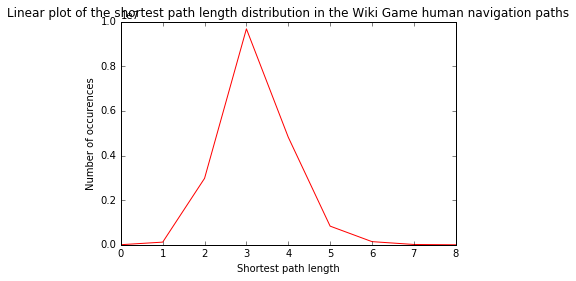

In [2]:
shortest_path_lengths_dict = nx.shortest_path_length(g)

shortest_path_lengths_values = [length for source, targets in shortest_path_lengths_dict.iteritems() for target, length in targets.iteritems()]

# Compute the bins for our degree distribution
bins = [i for i in range(min(shortest_path_lengths_values), max(shortest_path_lengths_values) + 1)]

shortest_path_lengths_values_hist, shortest_path_lengths_values_bin = np.histogram(shortest_path_lengths_values, bins=bins)

plt.plot(shortest_path_lengths_values_bin[:-1], shortest_path_lengths_values_hist, 'r')
plt.xlabel('Shortest path length')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the shortest path length distribution in the Wiki Game human navigation paths')
plt.show()

* ** For each source/target pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. If I ignore back steps, I get this on log-log scale: **

In [3]:
human_path_lengths_dict = {}

with open(PATHS_DIR + 'paths_finished.tsv') as f:
    # Skip the first 16 lines (header lines)
    for _ in xrange(16):
        next(f)
    for line in f:
        content = line.split('\t')
        path = urllib.unquote(content[3]).decode('utf8').split(';')
        source, target = path[0], path[-1]
        
        if source == target:
            continue
        
        count = 0
        for article in path:
            if article != '<':
                count += 1
            else:
                count += 2
        
        if source in human_path_lengths_dict:
            if target in human_path_lengths_dict[source]:
                human_path_lengths_dict[source][target].append((count, path))
            else:
                human_path_lengths_dict[source][target] = [(count, path)]
        else:
            human_path_lengths_dict[source] = {target: [(count, path)]}

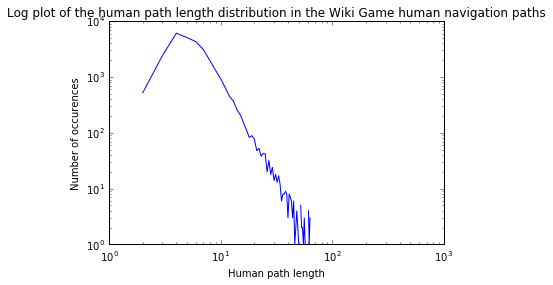

In [4]:
human_path_lengths = []
for source, targets in human_path_lengths_dict.iteritems():
    for target, counts_tuples in targets.iteritems():
        counts = [count for count, path in counts_tuples]
        human_path_lengths.append(np.average(counts))
        
# Compute the bins for our degree distribution
bins = [i for i in range(int(min(human_path_lengths)), int(max(human_path_lengths)) + 1)]

human_path_lengths_hist, human_path_lengths_bin = np.histogram(human_path_lengths, bins=bins)

plt.loglog(human_path_lengths_bin[:-1], human_path_lengths_hist, 'b')
plt.xlabel('Human path length')
plt.ylabel('Number of occurences')
plt.title('Log plot of the human path length distribution in the Wiki Game human navigation paths')
plt.show()

We chose to use a penalty of 1 when using a back click (incrementing the count by 2), as this represents the overhead of moving to that page, and coming back on the previous page.

* **How much longer are the human paths on average?**

In [5]:
avg_human_paths = np.average(human_path_lengths)
avg_shortest_paths = np.average(shortest_path_lengths_values)

print "On average, human paths are %.1f nodes longer than the shortest path" % (avg_human_paths - avg_shortest_paths)

On average, human paths are 3.6 nodes longer than the shortest path


* **Create scatter plot where each point is a source/target pair, and you have human path lengths on the x-axis and shortests paths on the y-axis.**

In [6]:
human_and_shortest_lengths = {}
for source, targets in human_path_lengths_dict.iteritems():
    for target, counts_tuples in targets.iteritems():
        counts = [count for count, path in counts_tuples]
        if source in shortest_path_lengths_dict and target in shortest_path_lengths_dict[source]:
            human_and_shortest_lengths[(source, target)] = (np.average(counts), shortest_path_lengths_dict[source][target])

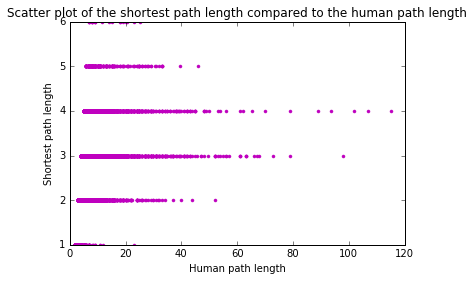

In [7]:
#print human_and_shortest_lengths
human_path_lengths = map(lambda ((s, t), (h,c)): h, human_and_shortest_lengths.iteritems())
shortest_path_lengths = map(lambda ((s, t), (h,c)): c, human_and_shortest_lengths.iteritems())

plt.plot(human_path_lengths, shortest_path_lengths, 'm.')
plt.xlabel('Human path length')
plt.ylabel('Shortest path length')
plt.title('Scatter plot of the shortest path length compared to the human path length')
plt.show()

* **Is there a correlation between human/shortest path-lengths? What is the correlation.**

> ??Probably.

## Betweenness

*Exercises*

* **Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset. Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.** 

In [8]:
betweenness_centrality = nx.betweenness_centrality(g)

In [9]:
shortest_path_links = nx.shortest_path(g)
navigations_paths_size = 0

navigation_centrality = {}
for node in nx.nodes(g):
    navigation_centrality[node] = 0.
    
for source, targets in shortest_path_links.iteritems():
    for target, path in targets.iteritems():
        navigations_paths_size += 1
        for node in path[1:-1]:
            navigation_centrality[node] += 1
            
for node, centrality in navigation_centrality.iteritems():
    navigation_centrality[node] /= navigations_paths_size

* 
    * **First, list the 5 pages with highest navigation centrality.**

In [10]:
navigation_centrality_sorted = sorted(navigation_centrality.iteritems(), key=lambda (k,v): -v)

print "Top 5 pages with highest navigation centrality:"
print navigation_centrality_sorted[:5]

Top 5 pages with highest navigation centrality:
[(u'United_States', 0.09799010123635314), (u'United_Kingdom', 0.05438586611922974), (u'Europe', 0.03613468785569833), (u'England', 0.03188778123950704), (u'Canada', 0.022446075575274272)]


* 
    * ** Second, list the 5 pages with highest betweenness centrality.**

In [11]:
betweenness_centrality_sorted = sorted(betweenness_centrality.iteritems(), key=lambda (k,v): -v)

print "Top 5 pages with highest betweenness centrality:"
print betweenness_centrality_sorted[:5]

Top 5 pages with highest betweenness centrality:
[(u'United_States', 0.09409037321391805), (u'United_Kingdom', 0.042384448784335955), (u'England', 0.03240281285403494), (u'Europe', 0.026991699473661496), (u'Africa', 0.024204176190154178)]


* 
    * ** Compare the two lists. Explain the differences between the two lists in your own words. **
    
    > ??
    
* ** Create a scatterplot of betweenness centrality vs. navigation centrality.**

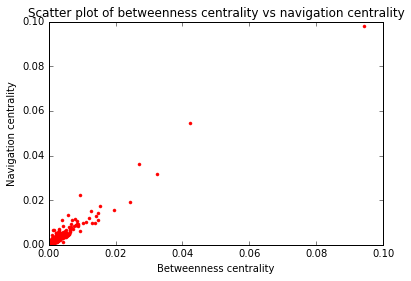

In [12]:
bw_centralities = []
nav_centralities = []
for node, bw_centrality in betweenness_centrality.iteritems():
    bw_centralities.append(bw_centrality)
    nav_centralities.append(navigation_centrality[node])

plt.plot(bw_centralities, nav_centralities, 'r.')
plt.xlabel('Betweenness centrality')
plt.ylabel('Navigation centrality')
plt.title('Scatter plot of betweenness centrality vs navigation centrality')
plt.show()

* 
    * ** Let's explore the pages that have navigation centrality equal to zero. **

        * ** How many pages have zero navigation centrality?**

In [13]:
zero_navigation_pages = [page for page, centrality in navigation_centrality.iteritems() if centrality == 0]

print "There are %d pages that have zero navigation centrality." % len(zero_navigation_pages)

There are 569 pages that have zero navigation centrality.


* 
    * 
        * **What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).**

In [14]:
zero_page_highest_btw = ''
highest_btw = 0
for page in zero_navigation_pages:
    current_btw_centrality = betweenness_centrality[page]
    if current_btw_centrality >= highest_btw:
        highest_btw = current_btw_centrality
        zero_page_highest_btw = page

print "The page with zero navigation centrality and highest betweenness centrality is : %s (%f)." % (zero_page_highest_btw, highest_btw)

The page with zero navigation centrality and highest betweenness centrality is : Brabantian (0.000009).


> ??

* 
    * 
        * **Plot the distribution of betweenness centrality for the pages with zero navigation centrality. My plot on log-log scale: **

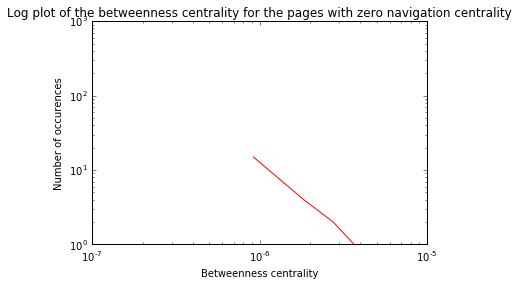

In [15]:
zero_navigation_pages_values = map(lambda k: betweenness_centrality[k], zero_navigation_pages)
#print zero_navigation_pages_values

zero_navigation_pages_hist, zero_navigation_pages_bin = np.histogram(zero_navigation_pages_values)

plt.loglog(zero_navigation_pages_bin[:-1], zero_navigation_pages_hist, 'r')
plt.xlabel('Betweenness centrality')
plt.ylabel('Number of occurences')
plt.title('Log plot of the betweenness centrality for the pages with zero navigation centrality')
plt.show()

* 
    * 
        * **Now, let's throw out all pages with zero navigation centrality and compare navigation- and betweenness centrality for the remaining pages.**

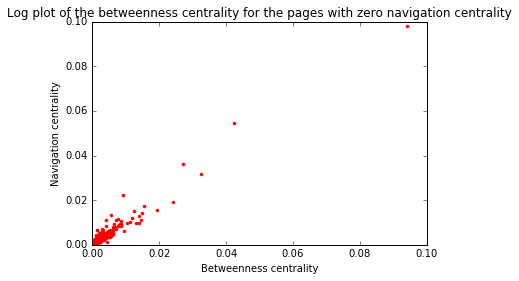

In [16]:
nav_centralities = []
bw_centralities = []

for node, centrality in navigation_centrality.iteritems():
    if node not in zero_navigation_pages:
        nav_centralities.append(centrality)
        bw_centralities.append(betweenness_centrality[node])

plt.plot(bw_centralities, nav_centralities, 'r.')
plt.xlabel('Betweenness centrality')
plt.ylabel('Navigation centrality')
plt.title('Log plot of the betweenness centrality for the pages with zero navigation centrality')
plt.show()

* 
    * 
        * 
            * **What is the correlation between betweenness centrality and navigation centrality?**

> ??

* 
    * 
        * 
            * **Comment on the top 5 outliers**

> ??

## Bringing the text into the picture

*Exercises*

* First, create a TF-IDF vector for each page. You already know all about TF-IDF from last week's exercise. The main difference is that we now characterize each page by a TF-IDF vector and not a group of pages.

    Second, write a function that calculates the distance between a pair of vectors. There are many ways to calculate distances between a pair of vectors (try a Google search for vector space distance measures if you want to refresh your knowledge on this topic). You're free to choose what you want, but we recommend the cosine similarity.

In [17]:
from __future__ import division
import nltk

wikipages_tokens = {}

# Collect english stopwords 
stopwords = set(nltk.corpus.stopwords.words('english'))

def is_alphanum(input_string):
    # TODO See if we need to do not all here instead (do we accept punctuation in words ?)
    return all(char.isalnum() for char in input_string)

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


def count_tokens_in_page(page, content):
    tokens = nltk.word_tokenize(content)
    
    # Remove extension from page as there are no extensions in the paths
    page = page.split('.')[0]
    page = urllib.unquote(page).decode('utf8')

    tokens_current_page = {}

    # Go through each token and check if we keep it
    for token in tokens:
        token_lower = token.lower()
        # if token is a part of the philosopher name, not alphanum (like punctuation), is a stopword, 
        # or is a number, discard it
        if len(token_lower) == 1 \
        or not is_alphanum(token_lower) \
        or is_number(token_lower) \
        or token_lower in stopwords: \
            continue
        # Add the token to the tokens of the current branch
#         if token_lower in tokens_current_page:
#             tokens_current_page[token_lower] += 1
#         else:
#             tokens_current_page[token_lower] = 1
        if token_lower in wikipages_tokens:
            if page in wikipages_tokens[token_lower]:
                wikipages_tokens[token_lower][page] += 1
            else:
                wikipages_tokens[token_lower][page] = 1
        else:
            wikipages_tokens[token_lower] = {page: 1}

    # Add the complete list of tokens to the branch 
    #wikipages_tokens[page] = tokens_current_page

def tf():
    wikipages_tokens_tf = {}
#     for page, tokens in wikipages_tokens.iteritems():
    for token, pages in wikipages_tokens.iteritems():
#         freq_tokens = [(token, 1+ np.log10(count)) for token, count in tokens.iteritems()]
        for page, count in pages.iteritems():
            if token in wikipages_tokens_tf:
                wikipages_tokens_tf[token][page] = 1+ np.log10(count)
            else:
                wikipages_tokens_tf[token] = {page: 1+ np.log10(count)}
#             if page in wikipages_tokens_tf:
#                 wikipages_tokens_tf[page].append((token, 1+ np.log10(count)))
#             else:
#                 wikipages_tokens_tf[page] = [(token, 1+ np.log10(count))]
#         wikipages_tokens_tf[page] = freq_tokens
    return wikipages_tokens_tf
        
def idf(N):
    wikipages_tokens_idf = {}
#     for page, tokens in wikipages_tokens.iteritems():
    for token, pages in wikipages_tokens.iteritems():
        token_count = 0
        for page, count in pages.iteritems():
            token_count += count
        wikipages_tokens_idf[token] = np.log10(N / token_count)
                                              
#         for token in tokens:
#             token_count = 0
#             for _, tokens1 in wikipages_tokens.iteritems():
#                 if token in tokens1:
#                     token_count += 1
#             wikipages_tokens_idf[token] = np.log10(N / token_count)
    return wikipages_tokens_idf
            

In [18]:
import os, io

wikipages = os.listdir('./wikigame/' + 'plaintext_articles/')

for page in wikipages:
    with io.open('./wikigame/' + 'plaintext_articles/' + page, 'r', encoding='utf-8') as f:
        content = f.read()
        count_tokens_in_page(page, content)

In [19]:
import numpy as np

wikipages_tokens_tf = tf()

In [20]:
wikipages_tokens_idf = idf(len(wikipages))

In [21]:
pages_tfidf = {}

for token, pages in wikipages_tokens_tf.iteritems():
    for (page, tf) in pages.iteritems():
        tfidf = wikipages_tokens_tf[token][page] * wikipages_tokens_idf[token]
        if page in pages_tfidf:
            pages_tfidf[page][token] = tfidf
        else:
            pages_tfidf[page] = {token: tfidf}

# for page, tfs in wikipages_tokens_tf.iteritems():
#     for (token, tf) in tfs:
#         tfidf = wikipages_tokens_tf[page] * wikipages_tokens_idf[token]
#         if page in pages_tfidf:
#             pages_tfidf[page][token] = tfidf
#         else:
#             pages_tfidf[page] = {token: tfidf}

In [22]:
#print [(page, tokens) for page, tokens in pages_tfidf.iteritems()][:1]

[(u'Hopman_Cup', {u'korda': 2.2317715507987668, u'world': -0.56385103056746599, u'coach': 1.1240592161649776, u'played': 0.21444195830791971, u'sanctioned': 1.7088928055184294, u'less': -0.017381494423500753, u'itf': 2.6631353149577541, u'wikipedia': -0.41367303611738981, u'guided': 1.4200972662714597, u'indoor': 1.3167823405071155, u'mainly': -0.15017874398808057, u'results': 0.4303932522370173, u'reviewed': 1.7440572225816804, u'four': -0.08960437897757384, u'helena': 1.4054567400885698, u'shape': 0.62650641959559306, u'selection': -0.066596280329281221, u'asian': 0.63864964725858731, u'immediately': 0.52546477772099909, u'consists': 0.69486744223763153, u'paul': 0.33782494324669304, u'subjects': -0.062939555257615826, u'one': -1.4096267320857181, u'blake': 2.0112154583295725, u'group': -0.13097066833178675, u'monitor': 1.4536203004151234, u'copyright': -0.016383428738035218, u'cup': 1.1482898795719534, u'rankings': 1.5170072792795162, u'queen': 0.27414652983304005, u'former': 0.0965

In [48]:
from scipy.spatial.distance import pdist, squareform

def calculate_distance_vectors(v1, v2):
    #X = zip(v1, v2)
    
    d = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    return d

def calculate_distance_matrix(X):
    d = pdist(X, 'cosine')
    d = squareform(d)
    return d

* Now you're ready for the exercises

    * **Calculate the average similarity for all human navigation paths (the source/target pairs from above). Calculate mean/variance of these average similarities.**

In [74]:
def compute_similarities_for_path(path, pages_tfidf):
    # Similiarities for current path
    similarities = []
    i = 0
    # Go through each page in the path
    while i < len(path)-1:
        # We consider 2 pages : the one at the current index, and the one just after
        p1_idx, p2_idx = i, i+1
        # While the other page to consider is a back click, go to the next page and go back one for the current page
        while path[p2_idx] == '<' and p2_idx < len(path) and p1_idx > 0:
            p2_idx += 1
            p1_idx -= 1
        # While the current page to consider is a back click, go back to the previous page
        while path[p1_idx] == '<' and p1_idx > 0:
            p1_idx -= 1

        # Update i (the index in the path array) to point to the new other page (so we can start at this index at next iteration)
        i = p2_idx

        p1, p2 = path[p1_idx], path[p2_idx]

        p1_tfidfs = []
        p2_tfidfs = []

        # If one of the pages isn't in our pages with associated tfidf, move on to the next iteration
        if p1 not in pages_tfidf or p2 not in pages_tfidf:
            continue

        # For each page sharing the same token, add the tfidf to their respective list
        token_seen = set()
        for p1_token, p1_tfidf in pages_tfidf[p1].iteritems():
            token_seen.add(p1_token)
            p1_tfidfs.append(p1_tfidf)
            if p1_token in pages_tfidf[p2]:
                p2_tfidfs.append(pages_tfidf[p2][p1_token])
            else:
                p2_tfidfs.append(0)
                
        for p2_token, p2_tfidf in pages_tfidf[p2].iteritems():
            if p2_token not in token_seen:
                p1_tfidfs.append(0)
                p2_tfidfs.append(p2_tfidf)

        # Now compute the distance between p1 vector and p2 vector
        d = calculate_distance_vectors(p1_tfidfs, p2_tfidfs)
        similarities.append(d)
    return similarities

In [75]:
#a,b,<,c,d
average_similarities = []
for source, targets in human_path_lengths_dict.iteritems():
    for target, counts_paths in targets.iteritems():
        for count, path in counts_paths:
            similarities = compute_similarities_for_path(path, pages_tfidf)
            average_similarities.append(np.average(similarities))

In [76]:
print "Average similarities stats:"
print "Mean: %f" % np.nanmean(average_similarities)
print "Variance: %f" % np.nanvar(average_similarities)
print "Min: %f" % min(average_similarities)
print "Max: %f" % max(average_similarities)

Average similarities stats:
Mean: 0.084350
Variance: 0.000763
Min: 0.011883
Max: 0.426796


* 
    * **Calculate the average similarity for all shortest paths between the source/target pairs. Calculate mean/variance of these average similarities. **

* 
    * **Plot the distributions of average similarities for both human- and shortest paths in a single plot. If everything works well, you should see something similar to the following: **

* 
    * **Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.**

* 
    * **Comment on your findings. Is H1 true?**